# Navigation Project report

A number of different agents were created to solve the 'Banana Navigation' game. A combination of These were:

1. Basic Deep Queue Network using experience replay, using a linear neural network model
2. Similar to 1, but including a 'Double' network
3. Building on 2, but also including a 'Dueling' network
4. Prioritised experience replay

All of these implementations 'solved' the solution in so much as they achieved an average score over 100 episodes > 13. Results of these are shown below.




## Designed for experimenting

The code implemented can be broadly broken down into three main areas:
- Agents classes
- NN models classes
- Experience Replay buffers classes

The goal is that these three elements can be mixed and matched in order to make it easy to experiment with different configurations.

So for example a different neural network model could be implemented and easily tested with both a normal experience replay buffer or a prioritised replay buffer and both of these configurations could utilise Double Q-Learning or not.

### Agents
A base agent class (BaseAgent) was implemented to support some common methods and attributes. Two sub classes were created, one to support basic replay buffers and the other to support priority experience type replay buffers. Currently the type of replay buffer is hard-coded to the specific agent, but this could be parameterised.

### NN Models
Any model can be used in conjunction with any of the agents implemented. Three models have been implemented:
- Basic linear model with three layers. The number of units for the two hidden layers can be provided as parameters
- Dueling linear model
- Conv2d model, specifically for the image based state

For all networks the number of output units is equal to the number of actions, so a single forward pass can determine the action.

### Experience Replay buffers
Two replay buffers have been implemented:
- ReplayBuffer: simply stores experiences and samples randomly
- PrioritizedReplayBuffer: this uses a sumtree to manage the prioritized experiences.

#### Prioritized Replay Buffer
The experiences themselves are stored in an array, with the adjusted priorities stored in a sumtree. 

When an experience is added its priority is not initially known (as this will only happen when sampled). As described in the paper [Prioritized Experience Replay](https://arxiv.org/pdf/1511.05952.pdf) all experiences should be sampled at least once, so these experiences are initially given a priority of 0 and put in a 'not prioritised' queue. When a request to provide a sample is made these unprioritised experiences will be provided before any other experiences. After an experience has been sampled its priority will be updated.

Priorities are adjusted by a constant, alpha as described in the paper.

Importance sampling weights are calculated when experiences are sampled and returned with the samples, so that the loss can be adjusted by these weights.

Both the alpha and beta (used in calculating importance sampling weights) constants are periodically adjusted. Alpha decaying slowly and beta annealing to 1. The constants for alpha and beta have been taken from the paper.

Sampling uses the priority of the experience. I divide the priority space into equal sized segments (batch size number of them) and then uniformally sample from these segments. I believe this is what the paper describes.



## Learning algorithms

A variety of approaches have been experimented with, these are described below.

### Experience replay
The fundamental approach adopted is described in the paper [Human-level control through deep reinforcement
learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf). The implementation uses two neural networks and an experience replay buffer.

### Double Q-learning
[Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/pdf/1509.06461.pdf) attempts to tackle the known problem of action values being overestimated in certain conditions. 
For DQN using the same values both to select and to evaluate an action makes it more likely that this overestimate will occur.
To prevent this the selection and evaluation of actions is decoupled. The selection of the action (using argmax) uses the local (online) network, whereas the evaluation uses the the target network.
In this implementation the base agent class (AgentBase) implements this feature so that it can be utilised independently of other features that may be used.

### Dueling network architectures
A duel network architecture as described in the paper [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/pdf/1511.06581.pdf) has been demonstrated to improve the performance of a reinforcment learning agent.
This approach has been implemented as the model DuelingQNetwork

### Prioritized Experience Replay
A prioritised experience replay buffer as described in the paper [Prioritized Experience Replay](https://arxiv.org/pdf/1511.05952.pdf) has been implemented.



## Plots of rewards for different agents

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import pandas as pd
import torch
import json
import matplotlib.pyplot as plt
%matplotlib inline

#%config InteractiveShell.ast_node_interactivity = 'all'

from lib.agents import AgentExperienceReplay, AgentPrioritizedExperienceReplay
from lib.models import QNetwork, DuelingQNetwork
from lib.dqn import dqn

#env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")
#env = UnityEnvironment(file_name="Banana.app")


# get the default brain
#brain_name = env.brain_names[0]
#brain = env.brains[brain_name]

# number of actions
#action_size = brain.vector_action_space_size
#print('Number of actions:', action_size)

# reset the environment
#env_info = env.reset(train_mode=False)[brain_name]

# number of agents in the environment
#print('Number of agents:', len(env_info.agents))

# examine the state space 
#state = env_info.vector_observations[0]
#print('States look like:', state)
#state_size = len(state)
#print('States have length:', state_size)

def create_dueling_model(state_size, action_size, seed):
    return DuelingQNetwork(state_size, action_size, seed)

def create_linear_model(state_size, action_size, seed):
    return QNetwork(state_size, action_size, seed)

all_scores = {}

all_scores_filename = 'scores.json'

def load_scores_from_file():
    with open(all_scores_filename) as fp:
        return json.load(fp)

def save_scores_to_file():
    with open(all_scores_filename, 'w') as fp:
        json.dump(all_scores, fp, sort_keys=True, indent=4)
        
all_scores = load_scores_from_file()
if not all_scores:
    print('no scores saved')
    all_scores = {}


## Overall best scores

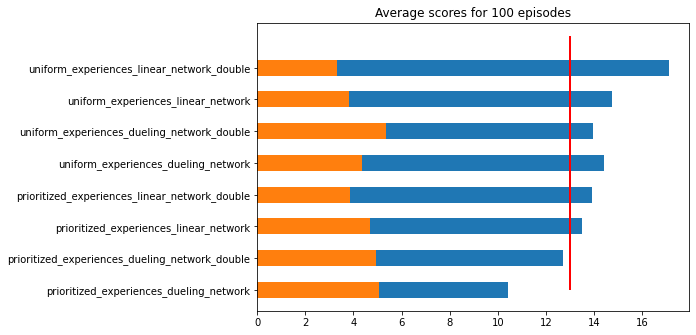

In [3]:

#for name, scores in all_scores.items():
#    plt.plot(scores, label = name)

#plt.title('Scores for 100 episodes')
#plt.legend()
#plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

avg = [np.mean(scores) for scores in all_scores.values()]
std = [np.round(pd.DataFrame(scores).std()[0],2) for scores in all_scores.values()]
ax.barh(list(all_scores.keys()), avg, 0.5)
ax.barh(list(all_scores.keys()), std, 0.5)

#plt.hlines(y=13, xmin=0, xmax=len(avg), colors='red', linestyles='-', lw=2, label='Game solved')
plt.vlines(x=13, ymin=0, ymax=len(avg), colors='red', linestyles='-', lw=2, label='Game solved')

plt.title('Average scores for 100 episodes')
plt.show()



## Learning speed

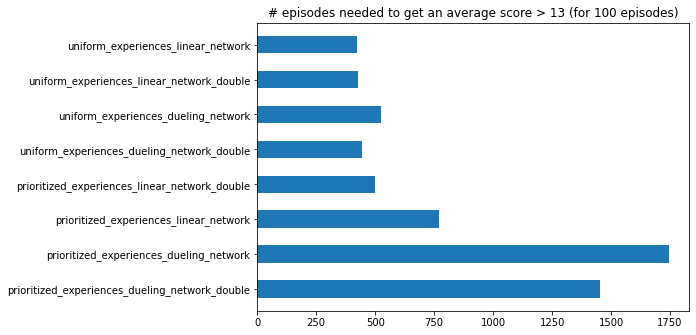

In [4]:
solved_episode_count = {
    'prioritized_experiences_dueling_network_double': 1454,
    'prioritized_experiences_dueling_network': 1744,
    'prioritized_experiences_linear_network': 769,
    'prioritized_experiences_linear_network_double': 499,
    'uniform_experiences_dueling_network_double': 444,
    'uniform_experiences_dueling_network': 525,
    'uniform_experiences_linear_network_double': 428,
    'uniform_experiences_linear_network': 424,
}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.barh(list(solved_episode_count.keys()), solved_episode_count.values(), 0.5)

plt.title('# episodes needed to get an average score > 13 (for 100 episodes)')
plt.show()

## Pixel Navigation

Some time was spent investigating creating an agent to learn using images of the game.

My initial approach has been to simplify the state space as the immediate impression is that two seamingly similar states of the game could produce very different states given slightly different colours. Investigating the images reveals there are a lot of different shades of yellow and blue. 
Additionally does the background in anyway add any useful information.

To try and simplify the image I used the opencv library to do the following
- convert the image from RGB to HSV as I believe this makes it easier to identify shades of a given colour
- use opencv inRange to create masks for yellow and blue regions
- identify edges and contours of the identified areas
- convert these contours to rectangles and fill with a single colour (one for yellow and one for blue)

The process generates a much simpler image, which although not extensively test appears to reasonably represent the original image. The bananas further away, particularly yellow ones are not always picked up, but I felt this wasn't necessarily a problem and thought (with no evidence) that this was perhaps preferable to increasing the colour range and consequently getting false positives.


### Examples of processed images

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


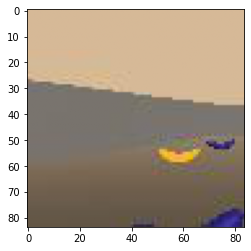

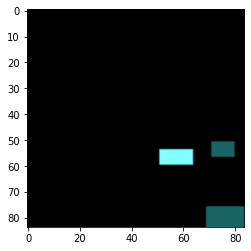

In [1]:
from unityagents import UnityEnvironment
from lib.image import process_image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


try:
    if 'env' in locals() and env._loaded:
        env.close()
except:
    pass

env = UnityEnvironment(file_name="VisualBanana_Linux/Banana.x86_64")
#env = UnityEnvironment(file_name="VisualBanana.app")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

action_size = brain.vector_action_space_size
state = env_info.visual_observations[0]
img = np.squeeze(state)
plt.imshow(img)
plt.show()

blue_boundaries=([120,145,50], [130,255,130])
yellow_boundaries=([18, 176, 235], [22, 227, 255])

processed_image, _, _ = process_image(img,
                                colour1_boundaries=blue_boundaries,
                                colour2_boundaries=yellow_boundaries)
plt.imshow(processed_image)
plt.show()
env.close()

### Dueling Network with Double Q-learning and Prioritized experience replay

Text(0, 0.5, 'Score')

Text(0.5, 0, 'Episode #')

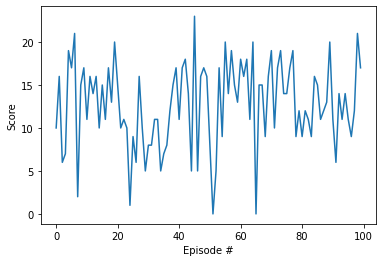

,0
count,100.000000
mean,12.720000
std,4.936117
min,0.000000
25%,9.750000
50%,13.000000
75%,16.250000
max,23.000000


4.936117150681548

In [25]:

agent_name = 'prioritized_experiences_dueling_network_double'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentPrioritizedExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                         create_model=create_dueling_model,
                                         double_dqn=True,
                                         train_mode=False
                                         )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

df = pd.DataFrame(all_scores[agent_name])
df.describe()
df.std()[0]

### Dueling Network with Prioritized experience replay

Episode 100	Average Score: 10.43


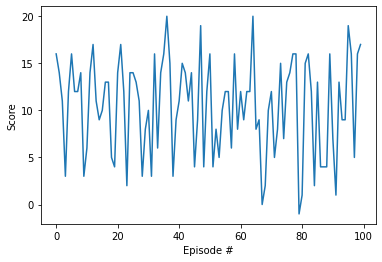

In [3]:

agent_name = 'prioritized_experiences_dueling_network'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentPrioritizedExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                         create_model=create_dueling_model,
                                         double_dqn=False,
                                         train_mode=False
                                         )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Linear Network with Prioritized experience replay

Episode 100	Average Score: 13.49


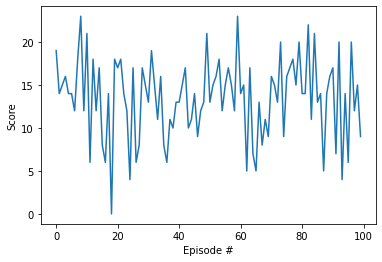

In [4]:

agent_name = 'prioritized_experiences_linear_network'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentPrioritizedExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                             create_model=create_linear_model,
                                             double_dqn=False,
                                             train_mode=False
                                             )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Linear Network with Double Q-learning and Prioritized experience replay

Episode 100	Average Score: 13.91


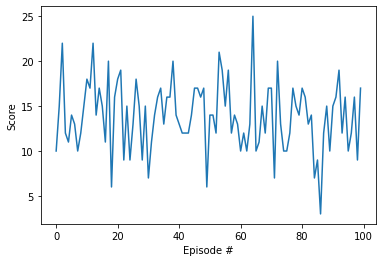

In [5]:
agent_name = 'prioritized_experiences_linear_network_double'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentPrioritizedExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                             create_model=create_linear_model,
                                             double_dqn=True,
                                             train_mode=False
                                             )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Dueling Network with Double Q-learning random experience replay

Episode 100	Average Score: 13.96


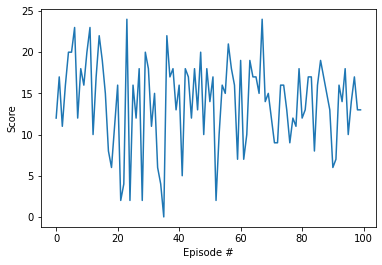

In [6]:

agent_name = 'uniform_experiences_dueling_network_double'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                  create_model=create_dueling_model,
                                  double_dqn=True,
                                  train_mode=False
                                  )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Dueling Network  random experience replay

Episode 100	Average Score: 14.41


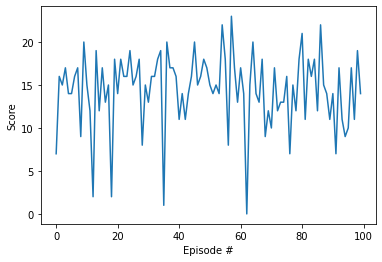

In [7]:

agent_name = 'uniform_experiences_dueling_network'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                  create_model=create_dueling_model,
                                  double_dqn=False,
                                  train_mode=False
                                 )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Linear Network with Double Q-learning random experience replay

Episode 100	Average Score: 17.10


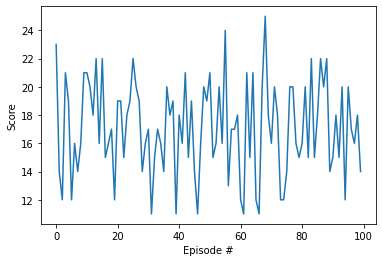

In [8]:

agent_name = 'uniform_experiences_linear_network_double'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                  create_model=create_linear_model,
                                  double_dqn=True,
                                  train_mode=False
                                 )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Linear Network with random experience replay

Episode 100	Average Score: 14.74


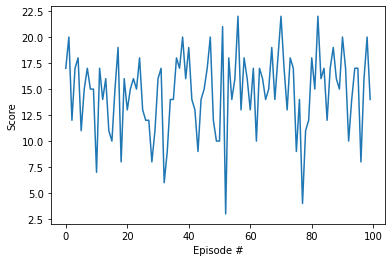

In [9]:

agent_name = 'uniform_experiences_linear_network'

if agent_name in all_scores: 
    scores = all_scores[agent_name]
else:
    env_info = env.reset(train_mode=False)[brain_name]
    agent = AgentExperienceReplay(state_size=state_size, action_size=action_size, seed=0, 
                                  create_model=create_linear_model,
                                  double_dqn=False,
                                  train_mode=False
                                  )
    agent.load_model(agent_name)
    scores = dqn(env,
                 brain_name,
                 agent,
                 train_mode=False,
                 n_episodes=100, 
                 eps_start=0.01)

    all_scores[agent_name] = scores
    save_scores_to_file()

# plot the scores 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Ideas for future work

### Experiment with a greater variety of Neural Network models
A lot more experimenting with different models is needed, I really didn't delve into this sufficiently due to time spent implementing the various algorthims described above.

### Using a DQN to 'learn' the best parameters

It feels like there is a lot of trial and error in order to determine the best architecture (e.g. network model, double q-learning etc) and hyperparameters. Would it be possible to define a DQN that could be used to determine what were the best set of values. Parameter values could be limited to discrete values so that the state space was managable. The reward could be the average score from a number of episodes of the game.

### Effective testing of subcomponents

With a lot of software, bugs are very obvious. With ML code it's possible to implement features, e.g. prioritized experience replay, which appear to 'work', in so much that the agent learns, but the implementation may not perform as intended. Whilst this issue is not limited to ML code, it does seem particularly vulnerable as some components may be difficult to verify.

### Image based navigation (pixel navigation)

I started to explore using an image of the game as the state, although ran out of time to actually solve it. I did wonder if you used a different reward than that provided by the environment. For example what if the reward was based on how yellow or blue (perhaps using the dot product to measure the yellowness/blueness), how would this effect the performance of the agent.
